# 2. Venues analysis notebook
----------------
-----------

## Table of contents <a name="contzs"></a>
* [Load venues info](#load)
* [Generic Venue Categories](#gvcatg)
    * [Cities overview by Generic Venue Category](#city_gvc)
* [Areas clustering via K-Means](#k-means)
    * [Clusters](#kmclus)
    * [View clusters graph and map](#kmclus_map)
* [Venue Tiers](#tiers)
    * [Cities overview by venue Tiers](#city_tiers)
* [Areas analysis](#areas)
    * [Areas overview by venue Tiers](#area_tiers)
    * [Areas ranking by Tiers](#area_rank)
    * [Areas final scoring](#area_score)
    * [Overview of top 10 areas](#top10a)

----
-----

Load libraries

In [2]:
%%time
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
# import json # library to handle JSON files
# from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
import folium # map rendering library
from folium.plugins import MarkerCluster  ######## for venue clusters
from bs4 import BeautifulSoup as bs
import fnmatch
import warnings
from sklearn.cluster import KMeans as km

print('Libraries imported.')

Libraries imported.
Wall time: 3.49 s


----
-----

### Loading venues database <a name="load"></a>

In [5]:
venuz = pd.read_csv('boroughs_list_with_coords_and_venues.csv')
venuz.tail()

,Borough,City+,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
14236,Macdonaldtown,"Sydney, Australia",-33.896783,151.186337,The Grandstand Sports Bar & Function Centre,-33.888584,151.184630,Sports Bar
14237,Macdonaldtown,"Sydney, Australia",-33.896783,151.186337,Made 590,-33.904055,151.180101,Clothing Store
14238,Macdonaldtown,"Sydney, Australia",-33.896783,151.186337,Domino's Pizza,-33.892520,151.187360,Pizza Place
14239,Macdonaldtown,"Sydney, Australia",-33.896783,151.186337,Hoochie Mamma Cafe,-33.892144,151.182998,Café
14240,Macdonaldtown,"Sydney, Australia",-33.896783,151.186337,Buon Gusto,-33.892610,151.192010,Italian Restaurant


In [6]:
venuz.shape

(14241, 8)

In [7]:
venuz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14241 entries, 0 to 14240
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Borough            14241 non-null  object 
 1   City+              14241 non-null  object 
 2   Borough Latitude   14241 non-null  float64
 3   Borough Longitude  14241 non-null  float64
 4   Venue              14241 non-null  object 
 5   Venue Latitude     14241 non-null  float64
 6   Venue Longitude    14241 non-null  float64
 7   Venue Category     14241 non-null  object 
dtypes: float64(4), object(4)
memory usage: 667.6+ KB


#### [back to contents](#contzs)

-------

### Unique city names

In [8]:
cities = pd.Series(sorted(list(venuz['City+'].unique()))).to_frame()
# cities.reset_index(drop=True,inplace=True)
# cities.rename(columns={0:'City+'}, inplace=True)
cities.columns = ['City+']
cities

,City+
0,"Dubai, United Arab Emirates"
1,"London, United Kingdom"
2,"Milan, Italy"
3,"New York, NY, United States"
4,"Paris, France"
5,"San Francisco, CA, United States"
6,"Singapore, Singapore"
7,"Sydney, Australia"
8,"Tokyo, Japan"
9,"Zurich, Switzerland"


In [9]:
# find which areas have a given venue category
v_catg = 'Arcade'  #''  #'Trail'
venuz.loc[ venuz['Venue Category']==v_catg ]

,Borough,City+,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1894,Marche,"Milan, Italy",45.496146,9.194824,Bingo Zara Milano Betterslot,45.495903,9.194479,Arcade
3945,Al Barsha 1 {*},"Dubai, United Arab Emirates",25.111254,55.195672,Magic Planet,25.118465,55.198679,Arcade
4366,Al Wasl - City Walk {*},"Dubai, United Arab Emirates",25.209912,55.259474,Hub Zero,25.206940,55.262489,Arcade
4389,Al Wasl - City Walk {*},"Dubai, United Arab Emirates",25.209912,55.259474,Play Town City Walk,25.207730,55.262301,Arcade
4437,Al Wasl - City Walk {*},"Dubai, United Arab Emirates",25.209912,55.259474,Fun City,25.216384,55.253283,Arcade
4663,Deira City Centre,"Dubai, United Arab Emirates",25.252227,55.332244,Magic Planet,25.251317,55.334054,Arcade
6160,Ogawamachi Station,"Tokyo, Japan",35.694967,139.766273,Hey - Hirose Entertainment Yard (Hey ヒロセエンターテイ...,35.699028,139.771161,Arcade
6174,Ogawamachi Station,"Tokyo, Japan",35.694967,139.766273,Sega (セガ 秋葉原5号館),35.698727,139.770650,Arcade
11254,Buena Vista Park {*},"San Francisco, CA, United States",37.767560,-122.443908,Free Gold Watch,37.768064,-122.452710,Arcade


In [10]:
# find similar venue categories by keyword + wildcard
v_catg = '*Restaurant*'   #'*Bar*'  #'*Market*'  #'*Shop*'  #'*Store*'
matching = fnmatch.filter(venuz['Venue Category'], v_catg)
pd.DataFrame(np.sort(pd.Series(matching).unique())).head(10)

,0
0,Afghan Restaurant
1,African Restaurant
2,American Restaurant
3,Arepa Restaurant
4,Argentinian Restaurant
5,Asian Restaurant
6,Australian Restaurant
7,Austrian Restaurant
8,Auvergne Restaurant
9,Basque Restaurant


### Unique venues categories

In [11]:
pd.set_option('display.max_rows', 30)
vencats = pd.Series(sorted(list(venuz['Venue Category'].unique()))).to_frame()
# cities.reset_index(drop=True,inplace=True)
# cities.rename(columns={0:'City+'}, inplace=True)
vencats.columns = ['VenCatg']
vencats  #.head()

,VenCatg
0,ATM
1,Accessories Store
2,Adult Boutique
3,Afghan Restaurant
4,African Restaurant
...,...
511,Yemeni Restaurant
512,Yoga Studio
513,Yoshoku Restaurant
514,Zoo


In [ ]:
# pd.set_option('display.max_rows', None)

In [ ]:
# %pwd

#### [back to contents](#contzs)

-------
-----------

## **Generic Venue Categories** <a name="gvcatg"></a>

Note that Generic Venue Categories are not exhaustive: 
they do not cover ALL categories of venues, only the 5 most common.

In [110]:
vencats = pd.read_csv('venue_categories_with_tiers+gvc.csv', index_col=0)
vencats.head(10)

,VenCatg,VenCatgTier,GenVenCatg
0,Accessories Store,Tier-2,Shops/Stores
1,Adult Boutique,Tier-3,Shops/Stores
2,Afghan Restaurant,Tier-2,Restaurants/Foods
3,African Restaurant,Tier-2,Restaurants/Foods
4,Airport,Tier-3,NaN
5,Alternative Healer,Tier-3,NaN
6,American Restaurant,Tier-2,Restaurants/Foods
7,Amphitheater,Tier-1,Arts/Culture
8,Animal Shelter,Tier-3,NaN
9,Antique Shop,Tier-2,Shops/Stores


In [111]:
# count by tier
vencats.groupby('VenCatgTier')['VenCatg'].count().to_frame()

,VenCatg
VenCatgTier,
Tier-1,57
Tier-2,345
Tier-3,125


In [112]:
# count by gvc
vencats.groupby('GenVenCatg')['VenCatg'].count().to_frame()

,VenCatg
GenVenCatg,
Arts/Culture,24
Bars/Pubs/Cafés,26
Parks/Outdoors,56
Restaurants/Foods,201
Shops/Stores,92


### Top10 venue categories per GVC

In [60]:
allvenues = pd.read_csv('all_venues_with_tiers+gvc.csv', index_col=0)
# allvenues.head()
allvenues['Generic Venue Category'].fillna('zzz', inplace=True)
gvc_uniq = sorted(list(allvenues['Generic Venue Category'].unique()))
top10gvc = pd.DataFrame()
for g in gvc_uniq: 
    g_iter = pd.Series( allvenues.pivot_table( index='Venue Category', columns='Generic Venue Category', aggfunc='count' )['Venue'].\
                  sort_values(by=g, ascending=False).head(10).index )
    top10gvc[g] = g_iter

# top10gvc.columns = gvc_uniq  # needed?
top10gvc.drop(columns='zzz', inplace=True)
top10gvc.index = top10gvc.index+1
print('Most frequent venue categories per GVC')
top10gvc

Most frequent venue categories per GVC


,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores
1,Theater,Café,Park,Italian Restaurant,Supermarket
2,Art Gallery,Coffee Shop,Plaza,French Restaurant,Grocery Store
3,Art Museum,Bar,Garden,Bakery,Bookstore
4,Museum,Pub,Playground,Japanese Restaurant,Clothing Store
5,Movie Theater,Cocktail Bar,Pool,Pizza Place,Spa
6,Historic Site,Wine Bar,Scenic Lookout,Chinese Restaurant,Boutique
7,Performing Arts Venue,Juice Bar,Trail,Restaurant,Convenience Store
8,Concert Hall,Sake Bar,Beach,Ice Cream Shop,Cosmetics Shop
9,Music Venue,Beer Bar,Beer Garden,Indian Restaurant,Shopping Mall
10,Monument / Landmark,Hotel Bar,Dog Run,Thai Restaurant,Gift Shop


In [65]:
# allvenues = pd.read_csv('all_venues_with_tiers+gvc.csv', index_col=0)
# allvenues.fillna('zzz',inplace=True)
# sorted(list(allvenues['Generic Venue Category'].unique()))

In [62]:
# gvc_uniq = 'Arts/Culture'
# gvc_piv = allvenues.pivot_table( index='Venue Category', columns='Generic Venue Category', aggfunc='count' )['Venue'].\
#                   sort_values(by=gvc_uniq, ascending=False).head(10)
# gvc_piv = gvc_piv.fillna(0).astype(int)
# gvc_piv

#### [back to contents](#contzs)

-------
-----------

### Cities overview by generic venue categories [to be put at the start] <a name="city_gvc"></a>

In [94]:
# reload venues info
venuz2 = pd.read_csv('all_venues_with_tiers+gvc.csv', index_col=0)
venuz2.tail()

,Area,City,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Tier,Generic Venue Category
14236,Macdonaldtown,Sydney,-33.896783,151.186337,The Grandstand Sports Bar & Function Centre,-33.888584,151.184630,Sports Bar,Tier-2,Bars/Pubs/Cafés
14237,Macdonaldtown,Sydney,-33.896783,151.186337,Made 590,-33.904055,151.180101,Clothing Store,Tier-2,Shops/Stores
14238,Macdonaldtown,Sydney,-33.896783,151.186337,Domino's Pizza,-33.892520,151.187360,Pizza Place,Tier-2,Restaurants/Foods
14239,Macdonaldtown,Sydney,-33.896783,151.186337,Hoochie Mamma Cafe,-33.892144,151.182998,Café,Tier-2,Bars/Pubs/Cafés
14240,Macdonaldtown,Sydney,-33.896783,151.186337,Buon Gusto,-33.892610,151.192010,Italian Restaurant,Tier-2,Restaurants/Foods


In [109]:
# groupby
# gvc_count = venuz2.groupby(['City','Generic Venue Category'])['Generic Venue Category'].count().to_frame()

# pivot
venuz2.rename(columns={'Generic Venue Category':'GVC'}, inplace=True)
gvc_count = venuz2.pivot_table( 'Venue', #[['Area','City','Venue Tier']] , 
                               index=['City'] , 
                               columns='GVC' , 
                               aggfunc='count' , margins=True, margins_name='Total Venues' )

gvc_count.rename(columns={'Arts/Culture':'Arts / Culture',
                          'Bars/Pubs/Cafés':'Bars / Pubs / Cafés',
                          'Parks/Outdoors':'Parks / Outdoors',
                          'Restaurants/Foods':'Restaurants / Foods',
                          'Shops/Stores':'Shops / Stores'}, inplace=True)
gvc_count.rename(index={'San Francisco':'S.Francisco'},inplace=True)
# gvc_count.iloc[-1,:] = gvc_count.iloc[-1,:].astype(str)
gvc_count.drop(index='Total Venues',inplace=True)
gvc_count.iloc[:,-1] = gvc_count.iloc[:,-1].astype(str)
gvc_count.style\
    .background_gradient(cmap=sb.light_palette("orange", as_cmap=True))\
    .set_caption('City table by GVC')
# counts to be NORMALIZED by number of areas considered per city!!

GVC,Arts / Culture,Bars / Pubs / Cafés,Parks / Outdoors,Restaurants / Foods,Shops / Stores,Total Venues
City,,,,,,
Dubai,20,295,88,693,173,1269
London,89,387,110,667,161,1414
Milan,67,212,86,766,154,1285
New York,75,239,123,748,217,1402
Paris,73,185,89,892,110,1349
S.Francisco,80,246,181,890,313,1710
Singapore,32,123,76,496,114,841
Sydney,23,431,96,537,89,1176
Tokyo,54,268,45,942,164,1473


In [108]:
# type(gvc_count.iloc[-2,0])
gvc_count.index.name

'City'

In [5]:
# counts to be NORMALIZED by number of areas considered per city!!

area_count = venuz2[['Area','City']].drop_duplicates().groupby('City').count()
area_count.rename(columns={'Area':'#Areas'}, inplace=True)
area_count = area_count.append(area_count.sum().rename('Total Areas'))
area_count.transpose()

City,Dubai,London,Milan,New York,Paris,San Francisco,Singapore,Sydney,Tokyo,Zurich,Total Areas
#Areas,16,16,15,16,15,19,12,14,16,11,150


In [121]:
gvc_count2 = gvc_count.join(area_count, on='City')
gvc_count2['#Areas'][10] = gvc_count2['#Areas'][0:10].sum()
gvc_count2

C:\Users\Tonin\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores,Total Venues,#Areas
City,,,,,,,
Dubai,20,295,88,693,173,1269,16.0
London,89,387,110,667,161,1414,16.0
Milan,67,212,86,766,154,1285,15.0
New York,75,239,123,748,217,1402,16.0
Paris,73,185,89,892,110,1349,15.0
San Francisco,80,246,181,890,313,1710,19.0
Singapore,32,123,76,496,114,841,12.0
Sydney,23,431,96,537,89,1176,14.0
Tokyo,54,268,45,942,164,1473,16.0


In [26]:
# save to file
# gvc_count2.to_csv('cities_by_gvc.csv')

In [122]:
gvc_count_avg = gvc_count2.copy()

for i in range(len(gvc_count_avg.index)):
    for c in range(len(gvc_count_avg.columns)):
        gvc_count_avg.iloc[i,c] = round(gvc_count2.iloc[i,c]/gvc_count2.iloc[i,6] , 1)
    
gvc_count_avg

,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores,Total Venues,#Areas
City,,,,,,,
Dubai,1.2,18.4,5.5,43.3,10.8,79.3,1.0
London,5.6,24.2,6.9,41.7,10.1,88.4,1.0
Milan,4.5,14.1,5.7,51.1,10.3,85.7,1.0
New York,4.7,14.9,7.7,46.8,13.6,87.6,1.0
Paris,4.9,12.3,5.9,59.5,7.3,89.9,1.0
San Francisco,4.2,12.9,9.5,46.8,16.5,90.0,1.0
Singapore,2.7,10.2,6.3,41.3,9.5,70.1,1.0
Sydney,1.6,30.8,6.9,38.4,6.4,84.0,1.0
Tokyo,3.4,16.8,2.8,58.9,10.2,92.1,1.0


In [123]:
gvc_count_avg.drop(columns='#Areas', inplace=True)
gvc_count_avg

,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores,Total Venues
City,,,,,,
Dubai,1.2,18.4,5.5,43.3,10.8,79.3
London,5.6,24.2,6.9,41.7,10.1,88.4
Milan,4.5,14.1,5.7,51.1,10.3,85.7
New York,4.7,14.9,7.7,46.8,13.6,87.6
Paris,4.9,12.3,5.9,59.5,7.3,89.9
San Francisco,4.2,12.9,9.5,46.8,16.5,90.0
Singapore,2.7,10.2,6.3,41.3,9.5,70.1
Sydney,1.6,30.8,6.9,38.4,6.4,84.0
Tokyo,3.4,16.8,2.8,58.9,10.2,92.1


In [29]:
# save to file
# gvc_count_avg.to_csv('cities_by_gvc_avg.csv')

In [124]:
gvc_count_avg2 = gvc_count_avg.copy() # drop(columns='#Areas') #, inplace=True)
gvc_count_avg2.drop(index='Total Venues', columns='Total Venues' , inplace=True)
gvc_count_avg2

,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores
City,,,,,
Dubai,1.2,18.4,5.5,43.3,10.8
London,5.6,24.2,6.9,41.7,10.1
Milan,4.5,14.1,5.7,51.1,10.3
New York,4.7,14.9,7.7,46.8,13.6
Paris,4.9,12.3,5.9,59.5,7.3
San Francisco,4.2,12.9,9.5,46.8,16.5
Singapore,2.7,10.2,6.3,41.3,9.5
Sydney,1.6,30.8,6.9,38.4,6.4
Tokyo,3.4,16.8,2.8,58.9,10.2


In [31]:
# save to file
# gvc_count_avg2.to_csv('cities_by_gvc_avg_nototals.csv')

### Cities overview graph by GVC

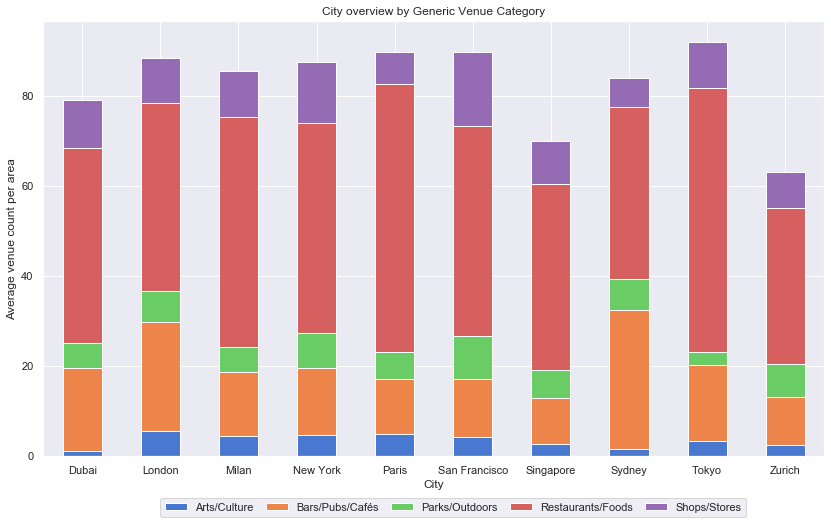

In [125]:
# data viz by histograms
# sb.set()

gvc_count_avg2.plot(kind ='bar', 
                figsize=(14,8),
                   width=0.5
                   ,stacked=True
                  )

plt.title('City overview by Generic Venue Category')
# plt.xlabel('City')
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel('Average venue count per area')
# plt.ylim(0,120)
plt.legend(bbox_to_anchor=(0.15, -0.14, 0.75, 1.), loc=3,
           ncol=5, mode="expand", borderaxespad=0.) #loc='best')
plt.grid(b=True)

# sb.set_style('darkgrid')

# plt.savefig('cities_by_gvc_NEW.png')

plt.show()

In [467]:
# sb.palplot(sb.color_palette())

#### [back to contents](#contzs)

-------
-----------

## **Areas K-Means Clustering** [after GVC; before Tiers] <a name="k-means"></a>

#### Preparatory analysis

In [70]:
# reload venues info
venuz2 = pd.read_csv('all_venues_with_tiers+gvc.csv', index_col=0)
venuz2.head()
# # trim info
# venuz2.drop(columns=['Borough Latitude','Borough Longitude']).head()

,Area,City,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Tier,Generic Venue Category
0,Altstadt,Zurich,47.372233,8.542329,Old Crow,47.372092,8.541024,Cocktail Bar,Tier-2,Bars/Pubs/Cafés
1,Altstadt,Zurich,47.372233,8.542329,Lindenhof,47.373005,8.540883,Pedestrian Plaza,Tier-1,Parks/Outdoors
2,Altstadt,Zurich,47.372233,8.542329,Widder Bar,47.372415,8.539863,Hotel Bar,Tier-2,Bars/Pubs/Cafés
3,Altstadt,Zurich,47.372233,8.542329,Widder Hotel,47.372449,8.539973,Hotel,Tier-2,NaN
4,Altstadt,Zurich,47.372233,8.542329,Café Schober,47.371400,8.544149,Café,Tier-2,Bars/Pubs/Cafés


In [71]:
venuz2.shape

(14241, 10)

In [72]:
venuz_onehot = pd.get_dummies(venuz2[['Venue Category']],prefix="",prefix_sep="")
venuz_onehot[['Area','City']] = venuz2[['Area','City']]
fixed_columns = [venuz_onehot.columns[-2],venuz_onehot.columns[-1]]+list(venuz_onehot.columns[:-2])
venuz_onehot = venuz_onehot[fixed_columns]
venuz_onehot.reset_index(drop=True).head()

,Area,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,...,Udon Restaurant,Unagi Restaurant,University,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Wagashi Place,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yemeni Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,Altstadt,Zurich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Altstadt,Zurich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Altstadt,Zurich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Altstadt,Zurich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Altstadt,Zurich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
venuz2.shape

(14241, 10)

In [74]:
venuz_grouped = venuz_onehot.groupby(['Area','City']).mean() #.reset_index()
venuz_grouped = venuz_grouped.sort_values(by=['City','Area']).reset_index()
venuz_grouped.head()

,Area,City,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,...,Udon Restaurant,Unagi Restaurant,University,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Wagashi Place,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yemeni Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,Al Barsha 1 {*},Dubai,0.0,0.01,0.0,0.00,0.00,0.000000,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.020000,0.01,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,Al Hudaiba Park,Dubai,0.0,0.00,0.0,0.00,0.00,0.013699,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.068493,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,Al Mankhool,Dubai,0.0,0.00,0.0,0.00,0.01,0.000000,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.020000,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,Al Rigga,Dubai,0.0,0.00,0.0,0.01,0.00,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.050000,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0
4,Al Satwa,Dubai,0.0,0.00,0.0,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.033708,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022472,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
venuz_grouped.shape

(150, 518)

In [49]:
# save to file
# venuz_grouped.to_csv('venuz_grouped.csv')

In [76]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Area','City']
for i in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    except:
        columns.append('{}th Most Common Venue'.format(i+1))  

# create a new dataframe
area_venues_mostfreq = pd.DataFrame(columns=columns)
area_venues_mostfreq[['Area','City']] = venuz_grouped[['Area','City']]

for j in np.arange(venuz_grouped.shape[0]):
    area_venues_mostfreq.iloc[j,2:] =\
        return_most_common_venues(venuz_grouped.iloc[j,1:], num_top_venues)

area_venues_mostfreq.reset_index(drop=True).head()

,Area,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Barsha 1 {*},Dubai,Hotel,Clothing Store,Coffee Shop,Boutique,Pakistani Restaurant,Restaurant,Grocery Store,Middle Eastern Restaurant,Lounge,Breakfast Spot
1,Al Hudaiba Park,Dubai,Café,Hotel,Middle Eastern Restaurant,Asian Restaurant,Coffee Shop,Chinese Restaurant,Convenience Store,Fried Chicken Joint,Dessert Shop,Bar
2,Al Mankhool,Dubai,Indian Restaurant,Hotel,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Supermarket,Restaurant,Pizza Place,Seafood Restaurant,Café
3,Al Rigga,Dubai,Hotel,Middle Eastern Restaurant,Coffee Shop,Asian Restaurant,Restaurant,Ice Cream Shop,Fast Food Restaurant,Lebanese Restaurant,Burger Joint,Indian Restaurant
4,Al Satwa,Dubai,Coffee Shop,Café,Hotel,Middle Eastern Restaurant,Restaurant,Electronics Store,Lounge,Indian Restaurant,Bar,Asian Restaurant


In [77]:
area_venues_mostfreq.shape

(150, 12)

In [157]:
# save to file
# area_venues_mostfreq.to_csv('area_venuz_most_freq.csv')

#### Attempt at finding optimal number k of clusters - Elbow Method

In [84]:
venuz_grouped_clustering = venuz_grouped.drop(columns=['Area','City'])

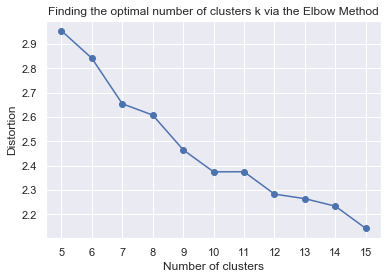

In [86]:
# optmize the number of clusters
# calculate distortion for a range of number of cluster
distortions = []
for i in range(5,15+1):
    kmz = km(n_clusters=i, 
             init='random', n_init=10, max_iter=300,tol=1e-04, 
             random_state=0 )
    kmz.fit(venuz_grouped_clustering)
    distortions.append(kmz.inertia_)

# plot
plt.plot(range(5,15+1), distortions, marker='o')
plt.xticks(np.arange(5,15+1, step=1))
plt.title('Finding the optimal number of clusters k via the Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
# plt.savefig('km-nclusters-elbow.png')
plt.show()

#### Attempt at finding optimal number k of clusters - Silhouette Method

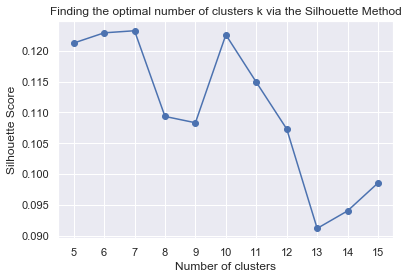

In [91]:
from sklearn.metrics import silhouette_score as silsc

sil = []
kmax = 15

# dissimilarity would not be defined for a single cluster, 
# thus, minimum number of clusters should be 2
for k in range(5, kmax+1):
    kmnz = km(n_clusters = k).fit(venuz_grouped_clustering)
    labels = kmnz.labels_
    sil.append(silsc(venuz_grouped_clustering, labels, metric = 'euclidean'))
    
# plot
plt.plot(range(5,15+1), sil, marker='o')
plt.xticks(np.arange(5,15+1, step=1))
plt.title('Finding the optimal number of clusters k via the Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
# plt.savefig('km-nclusters-silhouette12.png')
plt.show()

NB the higher the cluster number, the more likley each city will display its own cluster! --> should avoid any k equal or higher than #cities; ideally much lower than #cities to be able to identify potentially similar areas across different cities/countries

#### [back to contents](#contzs)

-------
-----------

#### Clustering areas via K-Means, into a number {kclusters} of clusters <a name="kmclus"></a>

In [189]:
# setting number of clusters = 7
# Elbow does not give clear indications, Silhouette does (peak=7/8)
kclusters = 7

# remove the 'postcodes' column
venuz_grouped_clustering = venuz_grouped.drop(columns=['Area','City'])

# run k-means clustering
kmeans = km(n_clusters=kclusters, random_state=0).fit(venuz_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_  #[0:10] 

array([0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 5, 0, 3, 5, 3, 3, 3, 3, 0, 5,
       3, 3, 5, 3, 3, 3, 3, 3, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 3, 2, 2, 2, 3, 4, 1, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 1, 3, 1, 3, 3, 3, 0, 1, 1, 3, 1, 1, 0, 3, 0, 0, 0, 1, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 3, 6, 6, 6, 6,
       6, 6, 3, 6, 6, 6, 6, 1, 4, 1, 5, 4, 4, 4, 4, 4, 4, 1])

In [190]:
kmeans.labels_.shape[0]

150

In [191]:
# show clusters distribution
clusters = pd.Series(kmeans.labels_).value_counts().to_frame()
clusters.index.rename('Area Cluster#', inplace=True)
clusters.rename(columns={0:'Area Count'}, inplace=True)
clusters.sort_values(by='Area Cluster#')

,Area Count
Area Cluster#,
0,18
1,12
2,9
3,53
4,23
5,21
6,14


#### Visualize map of clustered areas <a name="kmclus_map"></a>

In [266]:
# Create df to add cluster number label in the area df
area_venues_mostfreq.insert(2,'Cluster#', kmeans.labels_)
area_venues_mostfreq.head()

,Area,City,Cluster#,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Barsha 1 {*},Dubai,0,Hotel,Clothing Store,Coffee Shop,Boutique,Pakistani Restaurant,Restaurant,Grocery Store,Middle Eastern Restaurant,Lounge,Breakfast Spot
1,Al Hudaiba Park,Dubai,0,Café,Hotel,Middle Eastern Restaurant,Asian Restaurant,Coffee Shop,Chinese Restaurant,Convenience Store,Fried Chicken Joint,Dessert Shop,Bar
2,Al Mankhool,Dubai,0,Indian Restaurant,Hotel,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Supermarket,Restaurant,Pizza Place,Seafood Restaurant,Café
3,Al Rigga,Dubai,0,Hotel,Middle Eastern Restaurant,Coffee Shop,Asian Restaurant,Restaurant,Ice Cream Shop,Fast Food Restaurant,Lebanese Restaurant,Burger Joint,Indian Restaurant
4,Al Satwa,Dubai,0,Coffee Shop,Café,Hotel,Middle Eastern Restaurant,Restaurant,Electronics Store,Lounge,Indian Restaurant,Bar,Asian Restaurant


In [92]:
# add areas geo coords
area_coords = pd.read_csv('boroughs_list_with_coords.csv')
area_coords.rename(columns={'Borough':'Area'},inplace=True)

area_venues_mostfreq2 = area_venues_mostfreq.join(area_coords.set_index('Area'), on='Area')

area_venues_mostfreq2.drop(columns='City+',inplace=True)
fix_col = list(area_venues_mostfreq2.columns[:2])+\
               [area_venues_mostfreq2.columns[-2],area_venues_mostfreq2.columns[-1]]+\
            list(area_venues_mostfreq2.columns[2:-2])
area_venues_mostfreq2 = area_venues_mostfreq2[fix_col]

area_venues_mostfreq2.head()

,Area,City,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Barsha 1 {*},Dubai,25.111254,55.195672,Hotel,Clothing Store,Coffee Shop,Boutique,Pakistani Restaurant,Restaurant,Grocery Store,Middle Eastern Restaurant,Lounge,Breakfast Spot
1,Al Hudaiba Park,Dubai,25.241694,55.277478,Café,Hotel,Middle Eastern Restaurant,Asian Restaurant,Coffee Shop,Chinese Restaurant,Convenience Store,Fried Chicken Joint,Dessert Shop,Bar
2,Al Mankhool,Dubai,25.250827,55.295620,Indian Restaurant,Hotel,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Supermarket,Restaurant,Pizza Place,Seafood Restaurant,Café
3,Al Rigga,Dubai,25.267316,55.312268,Hotel,Middle Eastern Restaurant,Coffee Shop,Asian Restaurant,Restaurant,Ice Cream Shop,Fast Food Restaurant,Lebanese Restaurant,Burger Joint,Indian Restaurant
4,Al Satwa,Dubai,25.221161,55.273836,Coffee Shop,Café,Hotel,Middle Eastern Restaurant,Restaurant,Electronics Store,Lounge,Indian Restaurant,Bar,Asian Restaurant


In [268]:
area_venues_sorted.shape

(150, 15)

In [198]:
# save to file
# area_venues_mostfreq2.to_csv('area_venuz_most_freq_with_coords_and_clusters.csv')

In [217]:
# reload from file
area_venues_mostfreq2 = pd.read_csv('area_venuz_most_freq_with_coords_and_clusters.csv', index_col=0)
# area_venues_mostfreq2.head()

,Area,City,Latitude,Longitude,Cluster#,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Al Barsha 1 {*},Dubai,25.111254,55.195672,0,Hotel,Clothing Store,Coffee Shop,Boutique,Pakistani Restaurant,Restaurant,Grocery Store,Middle Eastern Restaurant,Lounge,Breakfast Spot
1,Al Hudaiba Park,Dubai,25.241694,55.277478,0,Café,Hotel,Middle Eastern Restaurant,Asian Restaurant,Coffee Shop,Chinese Restaurant,Convenience Store,Fried Chicken Joint,Dessert Shop,Bar
2,Al Mankhool,Dubai,25.250827,55.295620,0,Indian Restaurant,Hotel,Fast Food Restaurant,Coffee Shop,Chinese Restaurant,Supermarket,Restaurant,Pizza Place,Seafood Restaurant,Café
3,Al Rigga,Dubai,25.267316,55.312268,0,Hotel,Middle Eastern Restaurant,Coffee Shop,Asian Restaurant,Restaurant,Ice Cream Shop,Fast Food Restaurant,Lebanese Restaurant,Burger Joint,Indian Restaurant
4,Al Satwa,Dubai,25.221161,55.273836,0,Coffee Shop,Café,Hotel,Middle Eastern Restaurant,Restaurant,Electronics Store,Lounge,Indian Restaurant,Bar,Asian Restaurant


In [94]:
cluster_city_table = area_venues_mostfreq2.pivot_table('Area', index='City', columns='Cluster#', aggfunc='count')
                                                 #,margins=True, margins_name='Total Venues')
cluster_city_table.fillna(0).astype(int)

Cluster#,0,1,2,3,4,5,6
City,,,,,,,
Dubai,11,0,0,1,0,4,0
London,2,0,0,12,0,2,0
Milan,0,0,0,0,15,0,0
New York,0,0,0,16,0,0,0
Paris,0,1,9,4,1,0,0
San Francisco,0,3,0,16,0,0,0
Singapore,5,5,0,2,0,0,0
Sydney,0,0,0,0,0,14,0
Tokyo,0,0,0,2,0,0,14


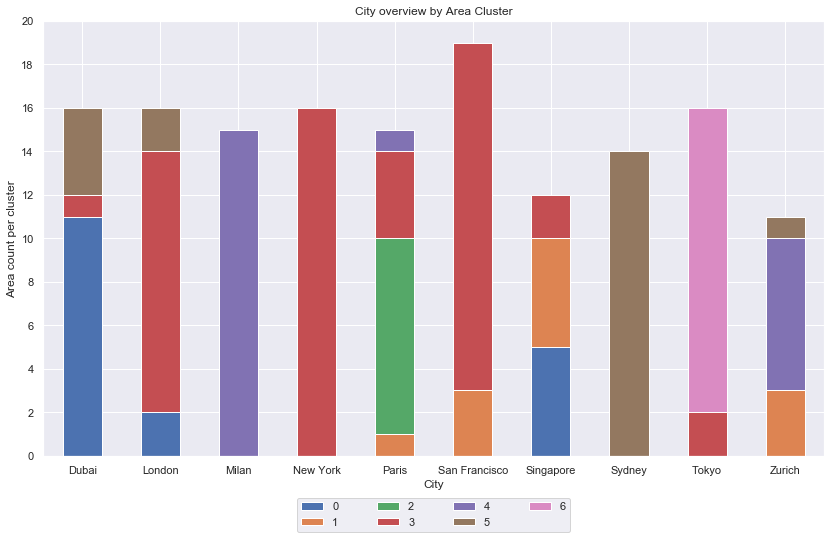

In [95]:
# clusters by city graph
cluster_city_table.plot(kind ='bar', figsize=(14,8),
                        width=0.5
#                         ,color=['darkblue','darkorange','hotpink','darkred'
#                                 ,'darkgreen','saddlebrown','indigo'] 
                        ,stacked=True
                        )

plt.title('City overview by Area Cluster')
# plt.xlabel('City')
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(np.arange(0,20+1, step=2))
plt.ylabel('Area count per cluster')
# plt.ylim(0,120)
plt.legend(bbox_to_anchor=(0.325, -0.175, 0.35, 1.), loc=3,
           ncol=4, mode="expand", borderaxespad=0.) #loc='best')
plt.grid(b=True)

# plt.savefig('clusters_by_city2.png')

plt.show()

In [96]:
# clusters by city map
map_clusters = folium.Map(location=[0,0], zoom_start=2)
# set color scheme for the clusters
# sb.set_palette("bright")
# import itertools; color_list = itertools.cycle(sb.color_palette())
# color_list = [ sb.color_palette()[c] for c in range(0,7) ]
color_list = ['blue','orange','limegreen','red','mediumpurple','peru','hotpink']
    #'darkblue','darkorange','darkgreen','darkred','purple','saddlebrown','hotpink']
    #'darkblue','darkorange','hotpink','darkred','darkgreen','saddlebrown','indigo']
    #'blue','orange','green','red','purple','yellow','pink']  

# add markers to the map
markers_colors = []
for lat, lon, area, cluster in zip(area_venues_mostfreq2['Latitude'], area_venues_mostfreq2['Longitude'], \
                                  area_venues_mostfreq2['Area'], area_venues_mostfreq2['Cluster#']):
    label = folium.Popup(str(area)+' - Cluster '+str(int(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color='black',  #color_list[cluster], #next(color_list)
        fill=True,
        fill_color=color_list[cluster],  #next(color_list)
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [97]:
# save map to file
# map_clusters.save(outfile= "clusters_map_world_2.html")

#### [back to contents](#contzs)

-------
-----------

### List of clustered areas

In [278]:
# set cluster # here
cluster = 3 
pd.set_option('display.max_rows', None)
area_venues_mostfreq.loc[ area_venues_mostfreq['Cluster#']==cluster ].head(10) #.to_csv('clusterchecks.csv')

,Area,City,Cluster#,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Umm Al Sheif,Dubai,3,Coffee Shop,Café,Pharmacy,Jewelry Store,Spa,Gym / Fitness Center,Grocery Store,Restaurant,Fast Food Restaurant,Sandwich Place
16,Angel,London,3,Pub,Coffee Shop,French Restaurant,Arts & Crafts Store,Pizza Place,Café,Theater,Gym / Fitness Center,Bakery,Japanese Restaurant
17,Battersea {*},London,3,Pub,Grocery Store,Bakery,Coffee Shop,Hotel,Bar,Café,Supermarket,Italian Restaurant,Pharmacy
18,Bond street,London,3,Hotel,French Restaurant,Burger Joint,Art Gallery,Clothing Store,Boutique,Juice Bar,Coffee Shop,Lounge,Department Store
19,Chelsea-Knightsbridge,London,3,Café,Ice Cream Shop,Coffee Shop,Exhibit,Hotel,Italian Restaurant,Gym / Fitness Center,Dessert Shop,Restaurant,Garden
22,Hammersmith,London,3,Pub,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Sandwich Place,Café,Bakery,Park,Thai Restaurant,French Restaurant
23,Holborn,London,3,Coffee Shop,Hotel,Theater,Bookstore,Pub,History Museum,Exhibit,Hotel Bar,English Restaurant,Restaurant
25,Nine Elms,London,3,Portuguese Restaurant,Pub,Café,Bar,Hotel,Coffee Shop,Indian Restaurant,Grocery Store,Gym / Fitness Center,Gastropub
26,Notting Hill,London,3,Italian Restaurant,Pub,Bakery,Gym / Fitness Center,Restaurant,Cocktail Bar,Bookstore,Breakfast Spot,Café,Bar
27,Paddington,London,3,Café,Pub,Coffee Shop,Garden,Hotel,Sandwich Place,Persian Restaurant,Argentinian Restaurant,Beer Bar,Bakery


#### [back to contents](#contzs)

-------
-----------

## **Venue Tiers** <a name="tiers"></a>

### Assign default venue tier = Tier-3

In [49]:
vencats['VenCatgTier'] = np.array(list('Tier-3' for i in range(len(vencats))))

In [89]:
vencats.head()

,VenCatg,VenCatgTier
0,ATM,Tier-3
1,Accessories Store,Tier-3
2,Adult Boutique,Tier-3
3,Afghan Restaurant,Tier-2
4,African Restaurant,Tier-2


### Main Tier overrides for more desirable venues

In [90]:
# restaurants 
v_catz = '*Restaurant*'   #'*Bar*'  #'*Market*'  #'*Shop*'  #'*Store*'
matches = fnmatch.filter(vencats['VenCatg'], v_catz)
uniq_matches = np.sort(pd.Series(matches).unique())
# uniq_matches
vencats.loc[ vencats['VenCatg'].isin(uniq_matches) , 'VenCatgTier'] = 'Tier-2'
# vencats.tail(20)

In [91]:
# bars
v_catz = '*Bar*'   #'*Bar*'  #'*Market*'  #'*Shop*'  #'*Store*'
matches = fnmatch.filter(vencats['VenCatg'], v_catz)
uniq_matches = np.sort(pd.Series(matches).unique())
# uniq_matches
vencats.loc[ vencats['VenCatg'].isin(uniq_matches) , 'VenCatgTier'] = 'Tier-2'
# vencats.tail(20)

In [92]:
# pubs
v_catz = '*Pub*'   #'*Bar*'  #'*Market*'  #'*Shop*'  #'*Store*'
matches = fnmatch.filter(vencats['VenCatg'], v_catz)
uniq_matches = np.sort(pd.Series(matches).unique())
# uniq_matches
vencats.loc[ vencats['VenCatg'].isin(uniq_matches) , 'VenCatgTier'] = 'Tier-2'
# vencats.loc[vencats['VenCatg']=='Pub' ]
# vencats.tail(20)

In [93]:
# shops
v_catz = '*Shop*'   #'*Bar*'  #'*Market*'  #'*Shop*'  #'*Store*'
matches = fnmatch.filter(vencats['VenCatg'], v_catz)
uniq_matches = np.sort(pd.Series(matches).unique())
# uniq_matches
vencats.loc[ vencats['VenCatg'].isin(uniq_matches) , 'VenCatgTier'] = 'Tier-2'
# vencats.tail(20)

In [101]:
# stores
v_catz = '*Store*'   #'*Bar*'  #'*Market*'  #'*Shop*'  #'*Store*'
matches = fnmatch.filter(vencats['VenCatg'], v_catz)
uniq_matches = np.sort(pd.Series(matches).unique())
# uniq_matches
vencats.loc[ vencats['VenCatg'].isin(uniq_matches) , 'VenCatgTier'] = 'Tier-2'
# vencats.tail(20)

In [94]:
# gardens
v_catz = '*Garden*'   #'*Bar*'  #'*Market*'  #'*Shop*'  #'*Store*'
matches = fnmatch.filter(vencats['VenCatg'], v_catz)
uniq_matches = np.sort(pd.Series(matches).unique())
# uniq_matches
vencats.loc[ vencats['VenCatg'].isin(uniq_matches) , 'VenCatgTier'] = 'Tier-1'
vencats.loc[vencats['VenCatg']=='Garden' ]
# vencats.tail(20)

,VenCatg,VenCatgTier
189,Garden,Tier-1


In [95]:
# parks
v_catz = ['Park','National Park','State / Provincial Park']   #'*Bar*'  #'*Market*'  #'*Shop*'  #'*Store*'
# matches = fnmatch.filter(vencats['VenCatg'], v_catz)
# uniq_matches = np.sort(pd.Series(matches).unique())
# uniq_matches
vencats.loc[ vencats['VenCatg'].isin(v_catz) , 'VenCatgTier'] = 'Tier-1'
vencats.loc[vencats['VenCatg']=='Park' ]
# vencats.tail(20)

,VenCatg,VenCatgTier
332,Park,Tier-1


In [103]:
# vencats.tail(20)

In [104]:
# save to file
# vencats.to_csv('venue_categories_with_tiers.csv')

### Top10 venue categories per Tier

In [195]:
allvenues = pd.read_csv('all_venues_with_tiers+gvc.csv', index_col=0)
# allvenues.head()
# allvenues.groupby( ['Venue Category'])['Venue Tier'].count().head()
t1 = list( allvenues.pivot_table( index='Venue Category', columns='Venue Tier', aggfunc='count' )['Venue'].\
    sort_values(by='Tier-1',ascending=False).head(10).index )
t2 = list( allvenues.pivot_table( index='Venue Category', columns='Venue Tier', aggfunc='count' )['Venue'].\
    sort_values(by='Tier-2',ascending=False).head(10).index )
t3 = list( allvenues.pivot_table( index='Venue Category', columns='Venue Tier', aggfunc='count' )['Venue'].\
    sort_values(by='Tier-3',ascending=False).head(10).index )
# t1

In [196]:
top10vt = pd.DataFrame( data={'Tier-1':t1, 'Tier-2':t2, 'Tier-3':t3} )
print('Most frequent venue categories per Tier')
top10vt.index = top10vt.index+1
top10vt

Most frequent venue categories per Tier


,Tier-1,Tier-2,Tier-3
1,Park,Café,Sandwich Place
2,Plaza,Coffee Shop,Burger Joint
3,Theater,Italian Restaurant,Vegetarian / Vegan Restaurant
4,Garden,Hotel,Yoga Studio
5,Deli / Bodega,French Restaurant,Fast Food Restaurant
6,Art Museum,Bakery,Nightclub
7,Food Court,Japanese Restaurant,Hostel
8,Museum,Pizza Place,Tram Station
9,Farmers Market,Bar,Salad Place
10,Pool,Chinese Restaurant,Bus Station


### Cities overview by venue Tiers [to be put at the end] <a name="city_tiers"></a>

In [13]:
# reload venues info 
venuz2 = pd.read_csv('all_venues_with_tiers+gvc.csv', index_col=0)
venuz2.head()

,Area,City,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Tier,Generic Venue Category
0,Altstadt,Zurich,47.372233,8.542329,Old Crow,47.372092,8.541024,Cocktail Bar,Tier-2,Bars/Pubs/Cafés
1,Altstadt,Zurich,47.372233,8.542329,Lindenhof,47.373005,8.540883,Pedestrian Plaza,Tier-1,Parks/Outdoors
2,Altstadt,Zurich,47.372233,8.542329,Widder Bar,47.372415,8.539863,Hotel Bar,Tier-2,Bars/Pubs/Cafés
3,Altstadt,Zurich,47.372233,8.542329,Widder Hotel,47.372449,8.539973,Hotel,Tier-2,NaN
4,Altstadt,Zurich,47.372233,8.542329,Café Schober,47.371400,8.544149,Café,Tier-2,Bars/Pubs/Cafés


In [90]:
tier_count = venuz2.pivot_table( 'Venue', #[['Area','City','Venue Tier']] , 
                               index=['City'] , 
                               columns='Venue Tier' , 
                               aggfunc='count' , margins=True, margins_name='Total Venues' )

tier_count.iloc[:,-1] = tier_count.iloc[:,-1].astype(str)
tier_count.drop(index='Total Venues',inplace=True)
tier_count.style\
    .background_gradient(cmap=sb.light_palette("orange", as_cmap=True))\
    .set_caption('City table by Venue Tiers')

Venue Tier,Tier-1,Tier-2,Tier-3,Total Venues
City,,,,
Dubai,94,1264,149,1507
London,205,1266,124,1595
Milan,128,1202,113,1443
New York,180,1282,138,1600
Paris,159,1285,56,1500
San Francisco,224,1485,176,1885
Singapore,123,761,124,1008
Sydney,122,1055,91,1268
Tokyo,85,1415,100,1600


In [73]:
# save to file
# tier_count.to_csv('cities_by_tier.csv')

In [74]:
# tier avg per area
tier_count_avg = tier_count.copy()

for i in range(len(tier_count_avg.index)):
    for c in range(len(tier_count_avg.columns)):
        tier_count_avg.iloc[i,c] = round(tier_count.iloc[i,c]/area_count.iloc[i,0] , 1)
    
tier_count_avg

Venue Tier,Tier-1,Tier-2,Tier-3,Total Venues
City,,,,
Dubai,5.9,79.0,9.3,94.2
London,12.8,79.1,7.8,99.7
Milan,8.5,80.1,7.5,96.2
New York,11.2,80.1,8.6,100.0
Paris,10.6,85.7,3.7,100.0
San Francisco,11.8,78.2,9.3,99.2
Singapore,10.2,63.4,10.3,84.0
Sydney,8.7,75.4,6.5,90.6
Tokyo,5.3,88.4,6.2,100.0


In [75]:
# save to file
# tier_count_avg.to_csv('cities_by_tier_avg.csv')

In [76]:
tier_count_avg2 = tier_count_avg.drop(index='Total Venues', columns='Total Venues') # , inplace=True)
tier_count_avg2

Venue Tier,Tier-1,Tier-2,Tier-3
City,,,
Dubai,5.9,79.0,9.3
London,12.8,79.1,7.8
Milan,8.5,80.1,7.5
New York,11.2,80.1,8.6
Paris,10.6,85.7,3.7
San Francisco,11.8,78.2,9.3
Singapore,10.2,63.4,10.3
Sydney,8.7,75.4,6.5
Tokyo,5.3,88.4,6.2


In [77]:
# save to file
# tier_count_avg2.to_csv('cities_by_tier_avg_nototals.csv')

### **Cities** overview graph by venue **Tiers**

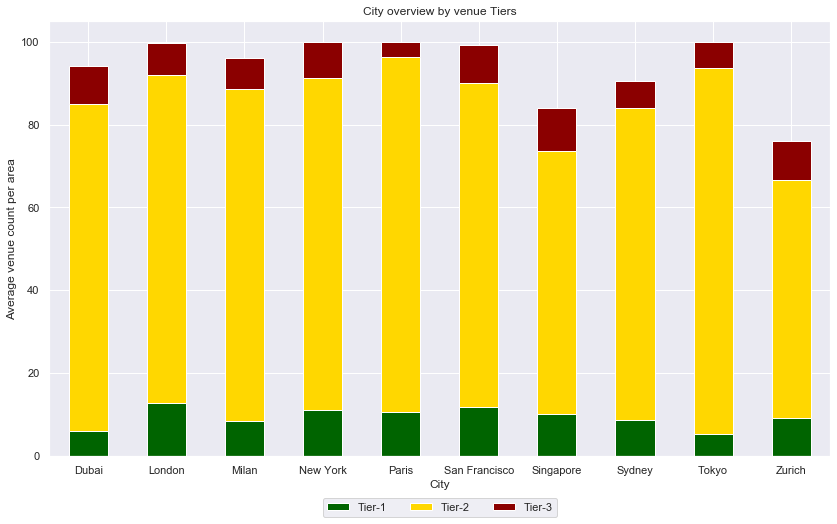

In [150]:
tier_count_avg2.plot(kind ='bar', 
                     figsize=(14,8),
                     width=0.5
                     , stacked=True
                     , color=('darkgreen', 'gold', 'darkred')
                         # 'gold','silver','darkgoldenrod') #'#5cb85c', '#5bc0de', '#d9534f')
                    )

plt.title('City overview by venue Tiers')
# plt.xlabel('City')
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel('Average venue count per area')

plt.legend(bbox_to_anchor=(0.35, -0.14, 0.3, 1.), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)  #loc='best')

plt.grid(b=True)

# sb.set_style('darkgrid')

# plt.savefig('cities_by_tier_NEW.png')

plt.show()

#### [back to contents](#contzs)

-------
-----------

## **Areas analysis** <a name="areas"></a>

### Consolidating venues info with Tier and GVC flags

In [15]:
# recalling venues info from above
venuz = pd.read_csv('boroughs_list_with_coords_and_venues.csv')
venuz.head()

,Borough,City+,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt,"Zurich, Switzerland",47.372233,8.542329,Old Crow,47.372092,8.541024,Cocktail Bar
1,Altstadt,"Zurich, Switzerland",47.372233,8.542329,Lindenhof,47.373005,8.540883,Pedestrian Plaza
2,Altstadt,"Zurich, Switzerland",47.372233,8.542329,Widder Bar,47.372415,8.539863,Hotel Bar
3,Altstadt,"Zurich, Switzerland",47.372233,8.542329,Widder Hotel,47.372449,8.539973,Hotel
4,Altstadt,"Zurich, Switzerland",47.372233,8.542329,Café Schober,47.371400,8.544149,Café


In [135]:
# 'Tokyo, Japan'.split(',')

In [193]:
venuz.rename(columns={'Borough':'Area'}, inplace=True)

venuz['City+'] = venuz['City+'].apply( lambda x: x.split(',')[0] )
venuz.rename(columns={'City+':'City'}, inplace=True)

venuz.tail()

,Area,City,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
14236,Macdonaldtown,Sydney,-33.896783,151.186337,The Grandstand Sports Bar & Function Centre,-33.888584,151.184630,Sports Bar
14237,Macdonaldtown,Sydney,-33.896783,151.186337,Made 590,-33.904055,151.180101,Clothing Store
14238,Macdonaldtown,Sydney,-33.896783,151.186337,Domino's Pizza,-33.892520,151.187360,Pizza Place
14239,Macdonaldtown,Sydney,-33.896783,151.186337,Hoochie Mamma Cafe,-33.892144,151.182998,Café
14240,Macdonaldtown,Sydney,-33.896783,151.186337,Buon Gusto,-33.892610,151.192010,Italian Restaurant


In [144]:
# pd.Series(venuz['City'].unique())

In [ ]:
# adding tier column 
# venuz['VenCatgTier'] = vencats['VenCatgTier'] for t in venuz['Venue Category']
# venuz['Venue Tier'] = venuz['Venue Category'].map(lambda x: vencats['VenCatgTier'][x])

# vencats.rename(columns={'VenCatg':'Venue Category'}, inplace=True)
# vencats.head()

# adding tier and gvc columns
venuz2 = venuz.join(vencats.set_index('VenCatg') , on='Venue Category')
venuz2.rename(columns={'VenCatgTier':'Venue Tier'}, inplace=True)
venuz2.rename(columns={'GenVenCatg':'Generic Venue Category'}, inplace=True)
venuz2.tail()

In [18]:
# save to file
# venuz2.to_csv('all_venues_with_tiers+gvc.csv')

#### [back to contents](#contzs)

-------
-----------

### **Areas** overview by venue **Tiers** <a name="area_tiers"></a>

In [24]:
# reload from file
venuz2 = pd.read_csv('all_venues_with_tiers+gvc.csv', index_col=0)

In [26]:
# groupby
# venuz_count = venuz2.groupby(['City','Area','Venue Tier'])['Venue Tier'].count().to_frame()

# pivot 
venuz_count = venuz2.pivot_table( 'Venue', #[['Area','City','Venue Tier']] , 
                                 index=['Area','City'] , 
                                 columns='Venue Tier' , 
                                 aggfunc='count' , margins=True, margins_name='Total Venues')   #.transpose()

pd.set_option('display.max_rows', None)
venuz_count.fillna(0,inplace=True)
venuz_count.sort_values(by=['City','Area']).head(10)

,Venue Tier,Tier-1,Tier-2,Tier-3,Total Venues
Area,City,,,,
Total Venues,,1421.0,11645.0,1175.0,14241
Al Barsha 1 {*},Dubai,4.0,87.0,9.0,100
Al Hudaiba Park,Dubai,2.0,65.0,6.0,73
Al Mankhool,Dubai,2.0,86.0,12.0,100
Al Rigga,Dubai,3.0,88.0,9.0,100
Al Satwa,Dubai,2.0,81.0,6.0,89
Al Wasl - City Walk {*},Dubai,3.0,86.0,11.0,100
Barsha Heights,Dubai,2.0,90.0,8.0,100
Business Bay,Dubai,3.0,94.0,3.0,100


In [89]:
# save to file
# venuz_count.to_csv('venuz_count_by_tier.csv')

#### [back to contents](#contzs)

-------
-----------

### **Ranking** areas by most Tier-1/2/3 venues <a name="area_rank"></a>

In [48]:
# venuz_count.index

In [86]:
warnings.filterwarnings("ignore")
venuz_rank = venuz_count.fillna(0).drop(index='Total Venues')
warnings.filterwarnings("default")
venuz_rank = venuz_rank.sort_values(by=['Tier-1','Tier-2','Tier-3'], ascending=False).reset_index() #.reset_index() #.astype(int)  #.drop(index='Total')
venuz_rank.index.name = 'Position'
venuz_rank.index = venuz_rank.index+1 
venuz_rank.columns.name = ''
venuz_rank.iloc[:,2:] = venuz_rank.iloc[:,2:].astype(int)
# venuz_rank.drop(columns='Total Venues',inplace=True)
venuz_rank.iloc[:,-1] = venuz_rank.iloc[:,-1].astype(str)
venuz_rank.head(10).style\
    .background_gradient(cmap=sb.light_palette("orange", as_cmap=True))\
    .set_caption('Areas Preliminary Ranking') #seagreen
#.drop(column='Venue Tier')
#drop=True,inplace=True

,Area,City,Tier-1,Tier-2,Tier-3,Total Venues
Position,,,,,,
1,Southwark,London,27,65,8,100
2,Marina South,Singapore,25,54,13,92
3,Buena Vista,San Francisco,24,62,14,100
4,East Harlem - 104th St,New York,23,72,5,100
5,Invalides - La Tour-Maubourg,Paris,22,76,2,100
6,Anderson Bridge,Singapore,22,65,13,100
7,Riesbach,Zurich,21,70,6,97
8,Place Monge,Paris,20,80,0,100
9,Lincoln Square - 66 St,New York,20,75,5,100


In [204]:
# venuz_rank.index
# venuz_rank.shape

(150, 4)

In [6]:
# save to file
# venuz_rank.to_csv('venuz_rank_by_tier2.csv')

### Check area venues per tier

In [75]:
area = 'Southwark' # 'Invalides - La Tour-Maubourg' # 'East Harlem - 104th St' #'Marina South'
tier = 'Tier-1'
print(area,',', tier,'venues composition')
venuz2.loc[ (venuz2['Area']==area)&(venuz2['Venue Tier']==tier),\
           ['Generic Venue Category','Venue Category','Venue'] ].\
    pivot_table(values='Venue', index=['Generic Venue Category','Venue Category'],\
                aggfunc='count', margins=True, margins_name='Total Venues')#.transpose()

Southwark , Tier-1 venues composition


Venue
Generic Venue Category Venue Category              
Arts/Culture           Art Museum                 3
                       Concert Hall               1
                       History Museum             1
                       Performing Arts Venue      2
                       Theater                    7
Parks/Outdoors         Park                       2
                       Pedestrian Plaza           1
                       Plaza                      1
                       Scenic Lookout             3
Restaurants/Foods      Deli / Bodega              1
                       Farmers Market             2
                       Street Food Gathering      3
Total Venues                                     27

In [187]:
# venuz2.loc[(venuz2['Area']==area)&(venuz2['Venue Tier']==tier)]

#### [back to contents](#contzs)

-------
-----------

### **Scoring** areas by venues Tiers <a name="area_score"></a>

In [28]:
warnings.filterwarnings("ignore")
venuz_score = venuz_count.drop(index='Total Venues') #, inplace=True) #.copy()
venuz_score['Total Score'] = np.array(list( 0 for i in range(len(venuz_score))))
warnings.filterwarnings("default")
venuz_score.sort_values(by=['City','Area']).head()

,Venue Tier,Tier-1,Tier-2,Tier-3,Total Venues,Total Score
Area,City,,,,,
Al Barsha 1 {*},Dubai,4.0,87.0,9.0,100,0
Al Hudaiba Park,Dubai,2.0,65.0,6.0,73,0
Al Mankhool,Dubai,2.0,86.0,12.0,100,0
Al Rigga,Dubai,3.0,88.0,9.0,100,0
Al Satwa,Dubai,2.0,81.0,6.0,89,0


In [606]:
# venuz_count
# venuz_count['Tier-1'][0]
# venuz_score['Score'][0]

### **Final scoring table**

In [87]:
# compute score
warnings.filterwarnings("ignore")
# weights
t1 = 7.0 ; t2 = 3.0 ; t3 = 1.0

for i in range(len(venuz_score.index)):
    venuz_score['Total Score'][i] = t1*venuz_count['Tier-1'][i] +\
                                t2*venuz_count['Tier-2'][i] + \
                                    t3*venuz_count['Tier-3'][i]

warnings.filterwarnings("default")
venuz_score_final = venuz_score.sort_values(by=['Total Score','Tier-1','Tier-2','Tier-3'], ascending=False).reset_index()
venuz_score_final.index.name = 'Position'
venuz_score_final.index = venuz_score_final.index+1 
venuz_score_final.columns.name = ''
venuz_score_final.iloc[:,2:] = venuz_score_final.iloc[:,2:].astype(int)
venuz_score_final.iloc[:,-2:] = venuz_score_final.iloc[:,-2:].astype(str)
venuz_score_final.head(10)\
    .style.background_gradient(cmap=sb.light_palette("orange", as_cmap=True))\
    .set_caption('Areas Final Ranking')

,Area,City,Tier-1,Tier-2,Tier-3,Total Venues,Total Score
Position,,,,,,,
1,Southwark,London,27,65,8,100,392
2,Invalides - La Tour-Maubourg,Paris,22,76,2,100,384
3,East Harlem - 104th St,New York,23,72,5,100,382
4,Place Monge,Paris,20,80,0,100,380
5,National Library (Richelieu),Paris,19,79,2,100,372
6,Lincoln Square - 66 St,New York,20,75,5,100,370
7,Buena Vista,San Francisco,24,62,14,100,368
8,West Bermondsey,London,16,84,0,100,364
9,Riesbach,Zurich,21,70,6,97,363


In [10]:
# save to file
# venuz_score.to_csv('venuz_score_by_tier2.csv')

### Most Frequent venues for top 10 areas

In [63]:
top10 = list(venuz_score_final.reset_index().set_index('Area').head(10).index)  #['Southwark','Invalides - La Tour-Maubourg','East Harlem - 104th St']
area_venues_mostfreq2 = pd.read_csv('area_venuz_most_freq_with_coords_and_clusters.csv', index_col=0)
top10_mostfreq = area_venues_mostfreq2.set_index('Area').drop(columns=['Latitude','Longitude'])
# top10_mostfreq.head()
top10_mostfreq = top10_mostfreq.loc[ top10_mostfreq.index.isin(top10) ]
# top10_mostfreq
# top10_mostfreq.sort_values(axis='index', by=venuz_score_final['Area'][:10]) #.head(10) 
top10_mostfreq['Area_ord'] = pd.Categorical(top10_mostfreq.index, 
                                           categories=list(venuz_score_final['Area'][:10]), 
                                           ordered=True )
top10_mostfreq.sort_values(by='Area_ord').drop(columns='Area_ord')

,City,Cluster#,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Area,,,,,,,,,,,,
Southwark,London,3,Pub,Theater,Coffee Shop,Hotel,Italian Restaurant,Street Food Gathering,Scenic Lookout,Seafood Restaurant,Restaurant,Art Museum
Invalides - La Tour-Maubourg,Paris,2,French Restaurant,Hotel,Italian Restaurant,Plaza,Historic Site,Garden,Coffee Shop,Cocktail Bar,History Museum,Bakery
East Harlem - 104th St,New York,3,Mexican Restaurant,Park,Gym,Coffee Shop,Deli / Bodega,Café,Pizza Place,Thai Restaurant,Bakery,Cocktail Bar
Place Monge,Paris,2,French Restaurant,Coffee Shop,Italian Restaurant,Café,Hotel,Science Museum,Bakery,Wine Bar,Plaza,Greek Restaurant
National Library (Richelieu),Paris,4,Hotel,Plaza,Japanese Restaurant,Historic Site,French Restaurant,Bakery,Italian Restaurant,Cocktail Bar,Coffee Shop,Pedestrian Plaza
Lincoln Square - 66 St,New York,3,Gym / Fitness Center,Italian Restaurant,Jazz Club,Plaza,Gym,Performing Arts Venue,Theater,American Restaurant,Bakery,Café
Buena Vista,San Francisco,3,Seafood Restaurant,Park,Chocolate Shop,Historic Site,Bike Rental / Bike Share,Ice Cream Shop,Coffee Shop,Sushi Restaurant,National Park,Tour Provider
West Bermondsey,London,3,Pub,Coffee Shop,Brewery,Italian Restaurant,Park,Cocktail Bar,Bakery,Bar,French Restaurant,Hotel
Riesbach,Zurich,4,Italian Restaurant,Swiss Restaurant,Café,Restaurant,Hotel,Supermarket,Tram Station,Park,Plaza,Museum


In [64]:
# top10_mostfreq.index
# list(venuz_score_final['Area'].values)[:10]
# pd.Series(venuz_score_final['Area'][:10])

#### [back to contents](#contzs)

-------
-----------

### Overview of **top 10 areas** <a name="top10a"></a>

In [95]:
# venuz2.head()
gvc_area = venuz2.pivot_table( 'Venue', #[[,'City','Venue Tier']] , 
                               index='Area' , 
                               columns='Generic Venue Category' , 
                               aggfunc='count' ).fillna(0) #, margins=True, margins_name='Total' )
gvc_area.head()

Generic Venue Category,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores
Area,,,,,
10th Arrondissement,0.0,19.0,1.0,69.0,3.0
11th Arrondissement,5.0,26.0,3.0,61.0,2.0
12th Arrondissement,3.0,9.0,7.0,53.0,13.0
14th Arrondissement,5.0,10.0,2.0,69.0,3.0
15th Arrondissement,0.0,8.0,4.0,74.0,3.0


In [121]:
# gvc_area.index

In [260]:
venuz_score_final2 = venuz_score_final.join(gvc_area, on='Area')
venuz_score_final2.head(10)

,,Tier-1,Tier-2,Tier-3,Total Venues,Total Score,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores
Area,City,,,,,,,,,,
Southwark,London,27.0,65.0,8.0,100,392,17.0,19.0,8.0,42.0,6.0
Invalides - La Tour-Maubourg,Paris,22.0,76.0,2.0,100,384,11.0,9.0,12.0,57.0,0.0
East Harlem - 104th St,New York,23.0,72.0,5.0,100,382,4.0,14.0,17.0,45.0,8.0
Place Monge,Paris,20.0,80.0,0.0,100,380,10.0,15.0,11.0,55.0,2.0
National Library (Richelieu),Paris,19.0,79.0,2.0,100,372,8.0,16.0,11.0,42.0,12.0
Lincoln Square - 66 St,New York,20.0,75.0,5.0,100,370,14.0,12.0,9.0,29.0,13.0
Buena Vista,San Francisco,24.0,62.0,14.0,100,368,8.0,6.0,20.0,44.0,12.0
West Bermondsey,London,16.0,84.0,0.0,100,364,5.0,30.0,8.0,47.0,5.0
Riesbach,Zurich,21.0,70.0,6.0,97,363,9.0,10.0,14.0,47.0,8.0


In [97]:
# save to file
# venuz_score_final2.to_csv('venuz_score_by_tier - incl_gvc.csv')

In [139]:
# load from file
venuz_score_final2 = pd.read_csv('venuz_score_by_tier - incl_gvc.csv', index_col=0)

venuz_score_final2.rename(columns={'Arts/Culture':'Arts / Culture',
                          'Bars/Pubs/Cafés':'Bars / Pubs / Cafés',
                          'Parks/Outdoors':'Parks / Outdoors',
                          'Restaurants/Foods':'Restaurants / Foods',
                          'Shops/Stores':'Shops / Stores'}, inplace=True)

venuz_score_final2.rename(index={'Anderson Bridge':'10.AndersonBr',
                                 'Riesbach':'9.Riesbach',
                                 'West Bermondsey':'8.W.Bermonds',
                                 'Buena Vista':'7.Buena Vista',
                                 'Lincoln Square - 66 St':'6.Lincoln Sq',
                                 'National Library (Richelieu)':'5.Ntl Library',
                                 'Place Monge':'4.Pl Monge',
                                 'East Harlem - 104th St':'3.E.Harlem',
                                 'Invalides - La Tour-Maubourg':'2.Invalides',
                                 'Southwark':'1.Southwark' }, inplace=True)

# venuz_score_final2.replace({'San Francisco':'S.Francisco'},inplace=True)
venuz_score_final2.drop(columns='City',inplace=True)
venuz_score_final2.iloc[:,:] = venuz_score_final2.iloc[:,:].astype(int)
venuz_score_final2.iloc[:,3:5] = venuz_score_final2.iloc[:,3:5].astype(str)

venuz_score_final2.head(10).style.background_gradient(cmap=sb.light_palette("orange", as_cmap=True)) #seagreen #lightblue

,Tier-1,Tier-2,Tier-3,Total Venues,Total Score,Arts / Culture,Bars / Pubs / Cafés,Parks / Outdoors,Restaurants / Foods,Shops / Stores
Area,,,,,,,,,,
1.Southwark,27,65,8,100,392,17,19,8,42,6
2.Invalides,22,76,2,100,384,11,9,12,57,0
3.E.Harlem,23,72,5,100,382,4,14,17,45,8
4.Pl Monge,20,80,0,100,380,10,15,11,55,2
5.Ntl Library,19,79,2,100,372,8,16,11,42,12
6.Lincoln Sq,20,75,5,100,370,14,12,9,29,13
7.Buena Vista,24,62,14,100,368,8,6,20,44,12
8.W.Bermonds,16,84,0,100,364,5,30,8,47,5
9.Riesbach,21,70,6,97,363,9,10,14,47,8


In [109]:
venuz_score_final2.shape

(150, 11)

In [30]:
top10_areas_tiersgvc0 = venuz_score_final2.head(10) #.reset_index() 
top10_areas_tiersgvc0.sort_values(by='Total Score', ascending=True, inplace=True)
# top10_areas_tiersgvc0
top10_areas_tiersgvc = top10_areas_tiersgvc0.reset_index().set_index('Area').drop(columns=['City','Total Venues','Total Score'])
top10_areas_tiersgvc

# for i in range(len(top10_areas_tiersgvc.index)):
#     top10_areas_tiersgvc['Area+'].iloc[i] = str(i+1,'. ',str(top10_areas_tiersgvc['Area'].iloc[i]) )                                           
                                        

C:\Users\Tonin\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Tier-1,Tier-2,Tier-3,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores
Area,,,,,,,,
Anderson Bridge,22.0,65.0,13.0,11.0,11.0,12.0,30.0,4.0
Riesbach,21.0,70.0,6.0,9.0,10.0,14.0,47.0,8.0
West Bermondsey,16.0,84.0,0.0,5.0,30.0,8.0,47.0,5.0
Buena Vista,24.0,62.0,14.0,8.0,6.0,20.0,44.0,12.0
Lincoln Square - 66 St,20.0,75.0,5.0,14.0,12.0,9.0,29.0,13.0
National Library (Richelieu),19.0,79.0,2.0,8.0,16.0,11.0,42.0,12.0
Place Monge,20.0,80.0,0.0,10.0,15.0,11.0,55.0,2.0
East Harlem - 104th St,23.0,72.0,5.0,4.0,14.0,17.0,45.0,8.0
Invalides - La Tour-Maubourg,22.0,76.0,2.0,11.0,9.0,12.0,57.0,0.0


In [17]:
top10_areas_tiersgvc.index #columns

Index(['Anderson Bridge', 'Riesbach', 'West Bermondsey', 'Buena Vista',
       'Lincoln Square - 66 St', 'National Library (Richelieu)', 'Place Monge',
       'East Harlem - 104th St', 'Invalides - La Tour-Maubourg', 'Southwark'],
      dtype='object', name='Area')

In [31]:
# rename areas; shorter, plus city initials; plus ranking position
top10_areas_tiersgvc.rename(index={'Anderson Bridge':'10. Anderson Br, SG'}, inplace=True)
top10_areas_tiersgvc.rename(index={'Riesbach':'9. Riesbach, ZU'}, inplace=True)
top10_areas_tiersgvc.rename(index={'West Bermondsey':'8. W.Bermondsey, LO'}, inplace=True)
top10_areas_tiersgvc.rename(index={'Buena Vista':'7. Buena Vista, SF'}, inplace=True)
top10_areas_tiersgvc.rename(index={'Lincoln Square - 66 St':'6. Lincoln Sq-66, NY'}, inplace=True)
top10_areas_tiersgvc.rename(index={'National Library (Richelieu)':'5. Ntl Library (Rich.), PA'}, inplace=True)
top10_areas_tiersgvc.rename(index={'Place Monge':'4. Place Monge, PA'}, inplace=True)
top10_areas_tiersgvc.rename(index={'East Harlem - 104th St':'3. E.Harlem-104, NY'}, inplace=True)
top10_areas_tiersgvc.rename(index={'Invalides - La Tour-Maubourg':'2. Invalides-LTM, PA'}, inplace=True)
top10_areas_tiersgvc.rename(index={'Southwark':'1. Southwark, LO'}, inplace=True)
top10_areas_tiersgvc

,Tier-1,Tier-2,Tier-3,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores
Area,,,,,,,,
"10. Anderson Br, SG",22.0,65.0,13.0,11.0,11.0,12.0,30.0,4.0
"9. Riesbach, ZU",21.0,70.0,6.0,9.0,10.0,14.0,47.0,8.0
"8. W.Bermondsey, LO",16.0,84.0,0.0,5.0,30.0,8.0,47.0,5.0
"7. Buena Vista, SF",24.0,62.0,14.0,8.0,6.0,20.0,44.0,12.0
"6. Lincoln Sq-66, NY",20.0,75.0,5.0,14.0,12.0,9.0,29.0,13.0
"5. Ntl Library (Rich.), PA",19.0,79.0,2.0,8.0,16.0,11.0,42.0,12.0
"4. Place Monge, PA",20.0,80.0,0.0,10.0,15.0,11.0,55.0,2.0
"3. E.Harlem-104, NY",23.0,72.0,5.0,4.0,14.0,17.0,45.0,8.0
"2. Invalides-LTM, PA",22.0,76.0,2.0,11.0,9.0,12.0,57.0,0.0


In [38]:
# save to file
# top10_areas_tiersgvc.to_csv('top10_areas_for_graphs.csv')

In [32]:
top10_areas_tiersgvc.iloc[:,:3]

,Tier-1,Tier-2,Tier-3
Area,,,
"10. Anderson Br, SG",22.0,65.0,13.0
"9. Riesbach, ZU",21.0,70.0,6.0
"8. W.Bermondsey, LO",16.0,84.0,0.0
"7. Buena Vista, SF",24.0,62.0,14.0
"6. Lincoln Sq-66, NY",20.0,75.0,5.0
"5. Ntl Library (Rich.), PA",19.0,79.0,2.0
"4. Place Monge, PA",20.0,80.0,0.0
"3. E.Harlem-104, NY",23.0,72.0,5.0
"2. Invalides-LTM, PA",22.0,76.0,2.0


#### Graph of top10 areas by Tier

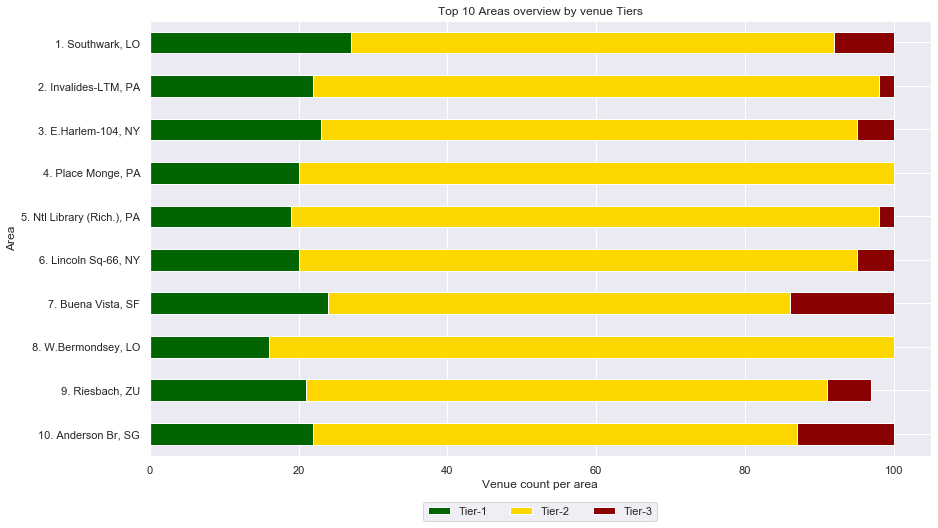

In [37]:
top10_areas_tiersgvc.iloc[:,:3].plot(kind ='barh', 
                     figsize=(14,8),
                     width=0.5
                     , stacked=True
                     , color=('darkgreen', 'gold', 'darkred') )

plt.title('Top 10 Areas overview by venue Tiers')
# plt.xlabel('City')
plt.xticks(rotation=0, horizontalalignment="center" ) # verticalalignment='top')
plt.xlabel('Venue count per area')

plt.legend(bbox_to_anchor=(0.35, -0.15, 0.3, 1.), loc=3,
           ncol=3, mode="expand", borderaxespad=0.)   #loc='best')
plt.grid(b=True)

# plt.savefig('top10_areas_by_tier.png')

plt.show()

#### [back to contents](#contzs)

-------
-----------

#### Graphs of top10 areas by GVC

In [34]:
# pd.concat( [venuz_score_final3.iloc[:,0:2],venuz_score_final3.iloc[:,7:12]], axis=1)
top10_areas_tiersgvc.iloc[:,3:8]

,Arts/Culture,Bars/Pubs/Cafés,Parks/Outdoors,Restaurants/Foods,Shops/Stores
Area,,,,,
"10. Anderson Br, SG",11.0,11.0,12.0,30.0,4.0
"9. Riesbach, ZU",9.0,10.0,14.0,47.0,8.0
"8. W.Bermondsey, LO",5.0,30.0,8.0,47.0,5.0
"7. Buena Vista, SF",8.0,6.0,20.0,44.0,12.0
"6. Lincoln Sq-66, NY",14.0,12.0,9.0,29.0,13.0
"5. Ntl Library (Rich.), PA",8.0,16.0,11.0,42.0,12.0
"4. Place Monge, PA",10.0,15.0,11.0,55.0,2.0
"3. E.Harlem-104, NY",4.0,14.0,17.0,45.0,8.0
"2. Invalides-LTM, PA",11.0,9.0,12.0,57.0,0.0


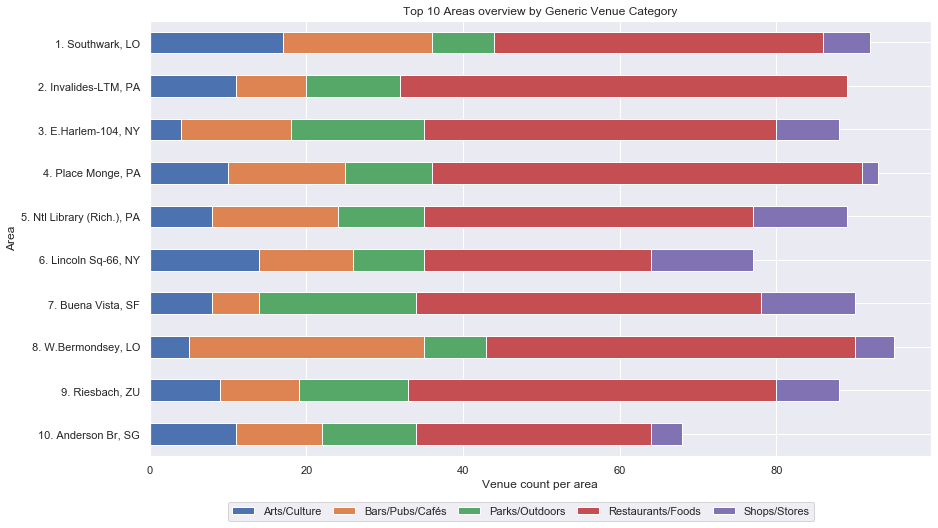

In [36]:
top10_areas_tiersgvc.iloc[:,3:8].plot(kind ='barh', 
                figsize=(14,8),
                   width=0.5
                   ,stacked=True )

plt.title('Top 10 Areas overview by Generic Venue Category')
# plt.xlabel('City')
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel('Venue count per area')
# plt.ylim(0,120)
plt.legend(bbox_to_anchor=(0.1, -0.15, 0.75, 1.), loc=3,
           ncol=5, mode="expand", borderaxespad=0.) #loc='best')
plt.grid(b=True)

# plt.savefig('top10_areas_by_gvc.png')

plt.show()

#### [back to contents](#contzs)

-------
-----------

#### [back to contents](#contzs)

-------
-----------